In [1]:
import os
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
class NUSW_NB15_Dataset(Dataset):
    def __init__(self, path, mode='all'):
        ds_type = path.split('/')[-1].split('-')[0]
        df = pd.read_csv(path)
        
        if mode == 'normal':
            # get only normal data
            df = df[df['label'] == 0]
        elif mode == 'anomaly':
            # get only anormal data
            df = df[df['label'] == 1]
        
        x = df.drop(['id', 'attack_cat', 'label'], axis=1)
        y = df['label']

        self.x = torch.Tensor(x.to_numpy())
        self.y = torch.Tensor(y.to_numpy())

        self.dim = self.x.shape[1]

        print(
            f'Finished reading the {ds_type} set ({mode}) of Dataset',
            f'({len(self.x)} samples found, each dim = {self.dim})'
        )

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    

def prep_dataloader(path, batch_size, shuffle, mode='all'):
    dataset = NUSW_NB15_Dataset(path, mode)
    
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle
    )

    return dataloader

In [3]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(196, 64),
            nn.ELU(),
            nn.Linear(64, 16),
            nn.ELU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ELU(),
            nn.Linear(64, 196),
            nn.ELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
def test(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    return test_loss

In [5]:
# config
# path
tr_path = '../../data/anomaly_detection/training-set.csv'
val_path = '../../data/anomaly_detection/validation-set.csv'
tt_path = '../../data/anomaly_detection/testing-set.csv'
log_path = '../../logs/anomaly_detection'
model_path = '../../models/anomaly_detection/AE_model_weights.pth'

# hyperparameter
epochs = 1000
batch_size = 64
lr = 1e-3

In [6]:
# prepare dataloader
normal_tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=True,
    mode='normal'
)

normal_val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=False,
    mode='normal'
)

normal_tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False,
    mode='normal'
)

all_tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=False,
    mode='all'
)

all_val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=False,
    mode='all'
)

all_tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False,
    mode='all'
)

Finished reading the training set (normal) of Dataset (59584 samples found, each dim = 196)
Finished reading the validation set (normal) of Dataset (14753 samples found, each dim = 196)
Finished reading the testing set (normal) of Dataset (18663 samples found, each dim = 196)
Finished reading the training set (all) of Dataset (164910 samples found, each dim = 196)
Finished reading the validation set (all) of Dataset (41228 samples found, each dim = 196)
Finished reading the testing set (all) of Dataset (51535 samples found, each dim = 196)


In [7]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# neural network
model = AE().to(device)

# loss func
loss_fn = nn.MSELoss()

# load model weight
print(f'Load model weights form {model_path}')
model.load_state_dict(torch.load(model_path))

Using cuda device
Load model weights form ../../models/anomaly_detection/AE_model_weights.pth


<All keys matched successfully>

In [8]:
tr_loss = test(normal_tr_dl, model, loss_fn, device)
val_loss = test(normal_val_dl, model, loss_fn, device)
tt_loss = test(normal_tt_dl, model, loss_fn, device)

pd.DataFrame({'avg loss': [tr_loss, val_loss, tt_loss]})\
    .set_axis(['train', 'val', 'test'])

,avg loss
train,0.000101
val,0.000104
test,0.000100


In [9]:
def create_loss_label_df(model, dl, device):
    losses = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            pred = model(x.to(device)).cpu().numpy()
            loss = np.mean(np.square(pred - x.numpy()), axis=1)
            losses.extend(loss)
            labels.extend(y.numpy().astype(np.int8))

    return pd.DataFrame({'loss': losses, 'label': labels})


def cal_threshold(df):
    normal_df = df[df['label'] == 0]
    return normal_df['loss'].mean() + normal_df['loss'].std()


def predict(losses, threshold):
    return list(map(lambda loss: 1 if loss > threshold else 0, losses))


def show_confusion_matrix(df, pred):
    conf_matrix = confusion_matrix(df['label'].values, pred)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix,
                xticklabels=['Not Attack', 'Attack'],
                yticklabels=['Not Attack', 'Attack'],
                annot=True,
                fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [10]:
tr_df = create_loss_label_df(model, all_tr_dl, device)
val_df = create_loss_label_df(model, all_val_dl, device)
tt_df = create_loss_label_df(model, all_tt_dl, device)

tr_threshold = 0.00006
print(f'threshold: {tr_threshold}\n')

tr_pred = predict(tr_df['loss'].values, tr_threshold)
val_pred = predict(val_df['loss'].values, tr_threshold)
tt_pred = predict(tt_df['loss'].values, tr_threshold)

print('training dataset\n')
print(classification_report(tr_df['label'].values, tr_pred))

print('validation dataset\n')
print(classification_report(val_df['label'].values, val_pred))

print('testing dataset\n')
print(classification_report(tt_df['label'].values, tt_pred))

threshold: 6e-05

training dataset

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     59584
           1       0.85      0.85      0.85    105326

    accuracy                           0.81    164910
   macro avg       0.79      0.79      0.79    164910
weighted avg       0.81      0.81      0.81    164910

validation dataset

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     14753
           1       0.85      0.85      0.85     26475

    accuracy                           0.81     41228
   macro avg       0.80      0.80      0.80     41228
weighted avg       0.81      0.81      0.81     41228

testing dataset

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     18663
           1       0.85      0.86      0.85     32872

    accuracy                           0.81     51535
   macro avg       0.80      0.80      0.80     51535
w

training dataset



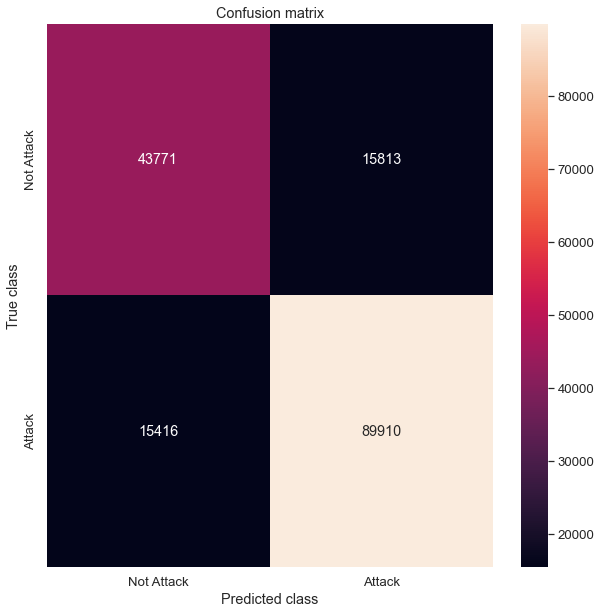

In [11]:
print('training dataset\n')
show_confusion_matrix(tr_df, tr_pred)

validation dataset



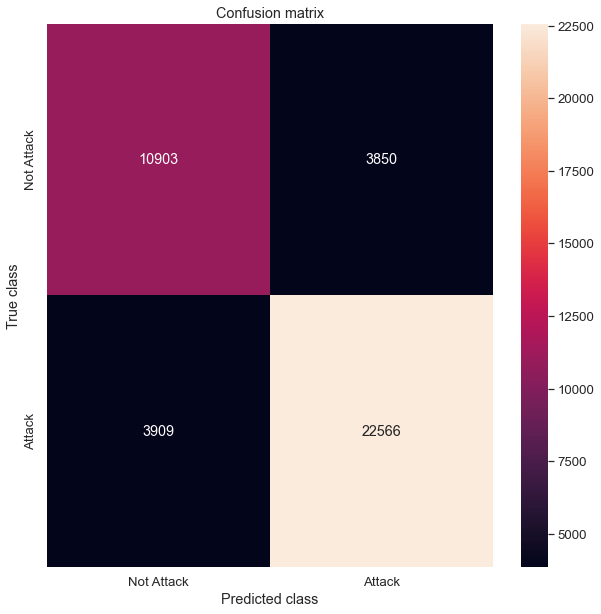

In [12]:
print('validation dataset\n')
show_confusion_matrix(val_df, val_pred)

testing dataset



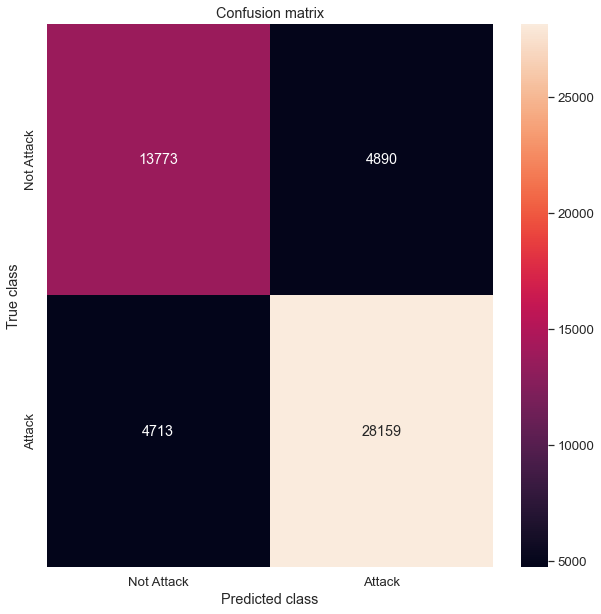

In [13]:
print('testing dataset\n')
show_confusion_matrix(tt_df, tt_pred)